---
### 1️⃣ Importando Bibliotecas & Modelo Treinado

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    classification_report, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

# Configurações de visualização
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")

In [4]:
# Importação do modelo treinado
model_path = [f for f in os.listdir("./Model") if f.endswith(".pkl")][-1] # Pega o mais recente
model_path = os.path.join("./Model", model_path)
model = joblib.load(model_path)

print(f"Carregando modelo: {model_path}")
model = joblib.load(model_path)

Carregando modelo: ./Model/XGB_RUS_21-00:15:50.pkl


---
### 2️⃣ Carregando Dataset & Predições

In [ ]:
# Carregando Dataset

df_view = pd.read_csv("train.csv")

X = df_view.drop(["Class", "id"], axis=1)
y = df_view["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

---
### 3️⃣ Visualização das Métricas

In [27]:
print("--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision (AUPRC): {avg_precision:.4f}")

--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     45490
           1       0.04      0.90      0.08        79

    accuracy                           0.96     45569
   macro avg       0.52      0.93      0.53     45569
weighted avg       1.00      0.96      0.98     45569

ROC-AUC: 0.9794
Average Precision (AUPRC): 0.6566


A partir dessa análise, é possível perceber clássicos resultados ao lidar com datasets extremamentes desbalanceados:

- *Precisão* baixíssima (apenas 4%), na prática o modelo gera muito mais falsos positivos do que realmente alerta fraudes reais.
    - Em produção isso pode ser amenizado, ajustando o `threshold` do modelo.

- *F1-Score* baixo pois a média harmônica é muito penalizada pela baixa precisão.

- *Acucária* elevada, é uma métrica bastante enganosa nesse dataset, pois quase sua totalidade são de *não fraudes*, ou seja, o fato de estar abaixo dos 99% é um bom indicativo de que o modelo está errando para tentar acertar uma possível fraude.

- *Average Precision* é uma métrica que indica o poder discriminatório do modelo, mesmo que a precisão esteja baixa, essa métrica está em um limiar sólido para esse tipo de dataset.

Por fim, o *Recall* está ótimo, o objetivo do modelo é justamente ter o mínimo de falsos negativos possível (mitigar riscos), e o *ROC-AUC* parece excelente.

> O uso do RUS no treinamento, é uma justificativa plausível na baixa precisão e alta sensibilidade, visto que o modelo foi treinado de forma que as fraudes parecem muito mais comuns do que são na realidade

---

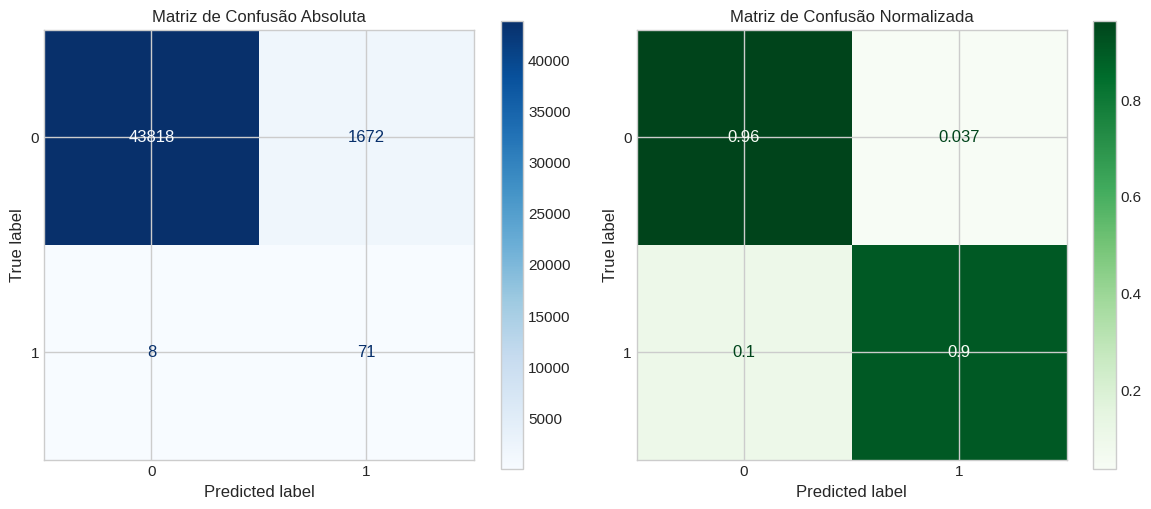

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0], cmap="Blues", values_format="d")
ax[0].set_title("Matriz de Confusão Absoluta")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[1], cmap="Greens", normalize="true")
ax[1].set_title("Matriz de Confusão Normalizada")

plt.tight_layout()
plt.show()

A partir dessas matrizes de confusão, é possível ver diretamente o comportamento do modelo comentado a partir das métricas anteriores:

- Das fraudes verdadeiras 71 foram capturadas pelo modelo (90%) e apenas 8 passaram como falsos negativos.

- O efeito rebote é que o número de falsos positivos foi relativamente grande (1672), embora seja um baixo percentual, pela grande quantidade de transações, é um valor relevante de alarmes falsos.

Mas, o custo de deixar uma fraude passar é maior do que os alarmes falsos, contudo depende dos procedimentos tomados pela equipe de antifraude, caso sejam muito agressivos, como bloqueio imediato da conta do cliente, se torna um ponto de melhoria importante para o modelo.

---

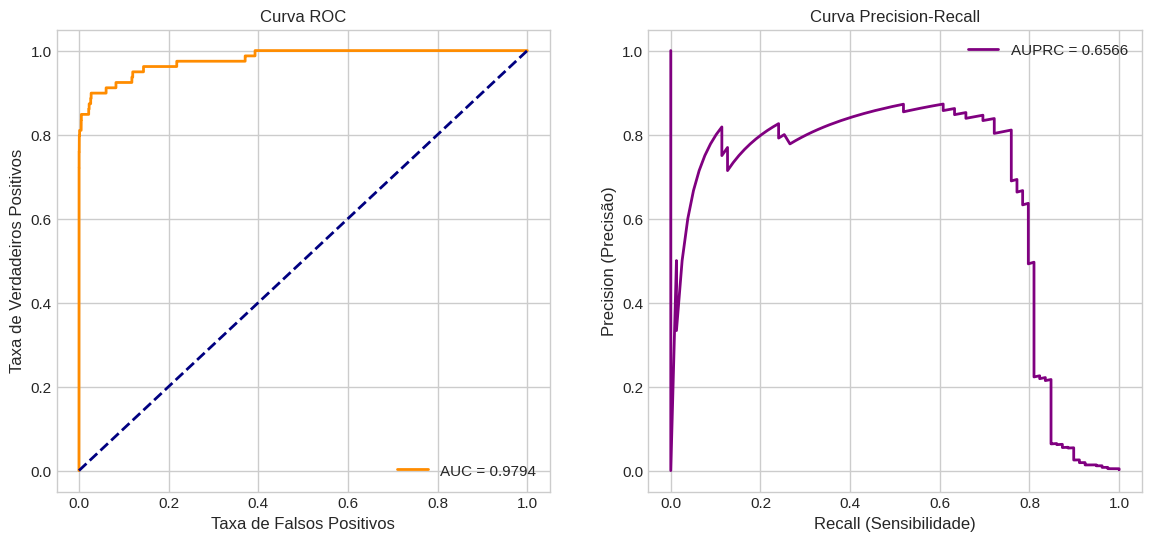

In [ ]:
# Comparação do AUC vs AUPRC

precision, recall, _ = precision_recall_curve(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
ax[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color="darkorange", lw=2)
ax[0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax[0].set_title("Curva ROC")
ax[0].set_xlabel("Taxa de Falsos Positivos")
ax[0].set_ylabel("Taxa de Verdadeiros Positivos")
ax[0].legend()

# Precision-Recall Curve
ax[1].plot(recall, precision, label=f"AUPRC = {avg_precision:.4f}", color="purple", lw=2)
ax[1].set_title("Curva Precision-Recall")
ax[1].set_xlabel("Recall (Sensibilidade)")
ax[1].set_ylabel("Precision (Precisão)")
ax[1].legend()

plt.show()

Esses gráficos mostram como o modelo funciona na realidade dos dados:

Enquanto o valor do ROC-AUC está excelente, indicando que o modelo é ótimo na separação entre as classes de *Fraude* & *Não Fraudes*, o valor do *AUPRC* mostra uma realidade diferente, na qual embora também não seja um valor ruim, o modelo apresenta dificuldade em manter uma boa precisão conforme a sensibilidade aumenta.
- Perceba, como a curva cai bruscamente para valores de recall acima de 80%

Analisando em conjunto com as matrizes anteriores, é justificado que o modelo está "viciado" em marcar *fraudes* graças ao `RUS`, o que torna o modelo bom em ranquear as classes mas com um ponto de corte baixo, causando excesso de falsos positivos.

---

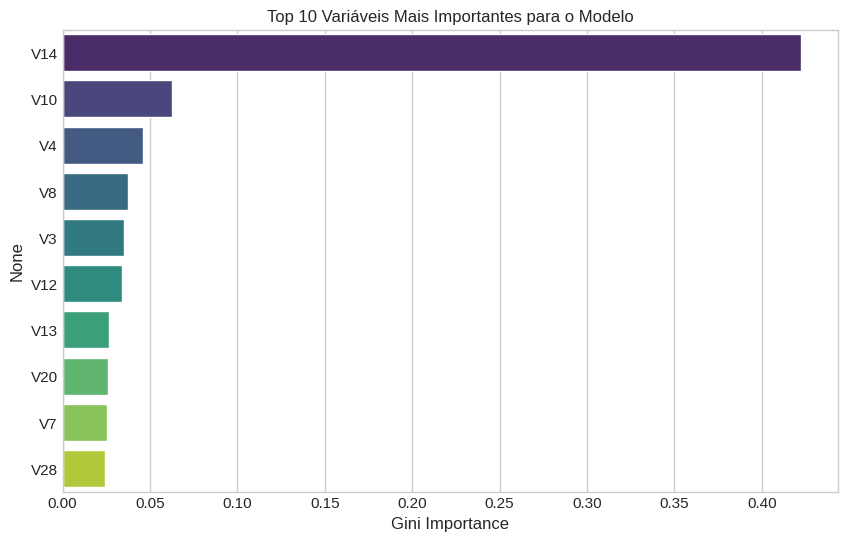

In [ ]:
# Feature Importance

feature_names = ["Time", "Amount"] + [f"V{i}" for i in range(1, 29)]

if hasattr(model, "best_estimator_"):
    clf = model.best_estimator_.named_steps["classifier"]
else:
    clf = model.named_steps["classifier"]

importances = pd.Series(clf.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, hue=importances.index, palette="viridis", legend=False)
plt.title("Top 10 Variáveis Mais Importantes para o Modelo")
plt.xlabel("Gini Importance")
plt.show()

Embora as variáveis não sejam muito autoexplicativas, por serem resultados da aplicação de PCA, analisar o Feature Importance do dataset, em relação as análises de correlação do EDA trazem bons insights.

- *V14* é a variável principal, ela domina o modelo com uma importância de acima de 40%, o que alinha-se com sua alta correlação com a classe de *Fraude* vista no EDA, além de justificar o porquê tentar cortar seus outliers causou uma degradação do modelo.

- Depois temos as variáveis *V10* & *V4* ambas que também possuiam valores elevados de correlação e auxiliam fortemente ao modelo na detecção de *Fraudes*.

- Por fim, a matriz de correlações e a importância das features na predição do modelo estão bem alinhados, o que evidencia a eficácia do PCA na captura dos componentes principais para detecção de comportamentos fraudulentos.

---
#### 🚀 Conclusão

O modelo é altamente preventivo, preferindo "errar para mais" (realizar falsos alarmes) do que permitir que muitas fraudes reais passem despercebidas.

Ademais, o `RUS` foi muito influente na melhora de predição do modelo, diminuindo o ruído do dataset,  permitindo que as features com alta correlação (analisadas na matriz de correlação do EDA) conseguissem explorar seu alto poder preditivo, como as variáveis *V14* & *V10*.

Por fim, com o resultado da alta sensibilidade e baixa precisão, o modelo funciona como uma ótima primeira camada de filtragem, necessitando de processos posteriores para reduzir a incidência de falsos positivos.

---
### 4️⃣ Submissão do Kaggle

In [5]:
import joblib
import pandas as pd

# Carregar o modelo (Pipeline completo)
pipeline_carregado = joblib.load(model_path)

# Carregar dados do Kaggle
df_kaggle = pd.read_csv("test.csv")

X_test_final = df_kaggle.drop(columns=["id"]) 
y_probs = pipeline_carregado.predict_proba(X_test_final)[:, 1]

# Gerar submissão
submission = pd.DataFrame({
    "id": df_kaggle["id"],
    "target": y_probs
})
submission.to_csv("submissao_credit_fraud.csv", index=False)